# Task 3

## Imports

In [50]:
import ultralytics
import os
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import cv2
from IPython.display import Image
from ultralytics import YOLO

ultralytics.checks()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Core(TM) i7-10510U 1.80GHz)
Setup complete ✅ (8 CPUs, 15.4 GB RAM, 515.1/620.0 GB disk)


## Defining functions

In [51]:
def dice_similarity_coefficient(bb1, bb2):
    # Calculate the intersection area
    x1_int = max(bb1[0], bb2[0])
    y1_int = max(bb1[1], bb2[1])
    x2_int = min(bb1[2], bb2[2])
    y2_int = min(bb1[3], bb2[3])
    intersection_area = max(0, x2_int - x1_int) * max(0, y2_int - y1_int)

    # Calculate the areas of each bounding box
    area_bb1 = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    area_bb2 = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # Calculate the Dice similarity coefficient
    dice_coefficient = (2.0 * intersection_area) / (area_bb1 + area_bb2)

    return dice_coefficient

def check_results(bb_guesses, bb_truth):

    dice_coefficients = []
    
    for bb_guess in bb_guesses:
        dice_coefficients_bb = []
        
        for bb in bb_truth:
            dice_coefficient = dice_similarity_coefficient(bb_guess, bb)
            dice_coefficients_bb.append(dice_coefficient)

        # If there are no ground truth bounding boxes left, append 0 to the list
        # Otherwise, append the maximum dice similarity coefficient to the list
        if len(dice_coefficients_bb) == 0:
            dice_coefficients.append(0)
        else:
            dice_coefficients.append(max(dice_coefficients_bb))

    return dice_coefficients

In [52]:
df_lego_sets = pd.read_csv("data/values.csv")

## Load YOLO model

In [53]:
# Load a pretrained model
model = YOLO('yolov8s.pt')

# Create folder to save the results
try:
    folder_name = "results"
    os.mkdir(folder_name)
except FileExistsError:
    pass

input_image_folder = 'data/smol'

In [54]:
# Predict bounding boxes for the images without printing the results
results = model.predict(input_image_folder, stream=True) #, verbose=False)

boxes = []
for result in results:
    # Get bounding boxes object for bounding box outputs
    boxes.append(result.boxes)
    
    # Save image with bounding boxes and predictions to folder
    image_name = result.path.split(os.sep)[-1]
    result.save(filename=os.path.join(folder_name, image_name))

print(boxes[0])


image 1/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_1.jpg: 640x640 (no detections), 196.2ms
image 2/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_10.jpg: 640x640 1 airplane, 205.6ms
image 3/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_2.jpg: 640x640 (no detections), 316.0ms
image 4/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_3.jpg: 640x640 (no detections), 273.5ms
image 5/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_4.jpg: 640x640 1 cup, 1 banana, 247.3ms
image 6/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_5.jpg: 640x640 1 bed, 244.9ms
image 7/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_6.jpg: 640x640 (no detections), 299.1ms
image 8/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_7.jpg: 640x640 (no detections), 295.9ms
image 9/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_8.jpg: 640x640 1 kite, 266.4ms
image 10/10 /home/m/Desktop/2S/VC/proj/p2/data/smol/1_9.jpg: 640x640 (no detections), 192.1ms
Speed: 3.8ms preprocess, 253.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640

## Visualize results

In [55]:
def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names

def loadImage(num, dataDir="data/smol", size = 1):
    
    img = cv2.imread(os.path.join(dataDir, f'{num}'))
    img = cv2.resize(img, (0, 0), fx = size, fy = size)
    return img

def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.png', image)[1].tobytes()
    display(Image(data=img_bytes))

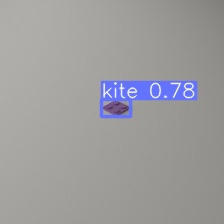

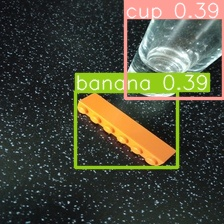

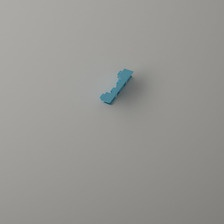

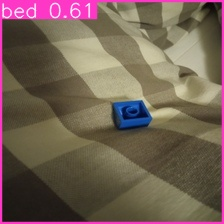

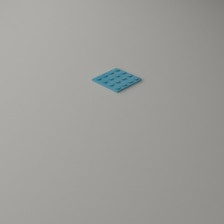

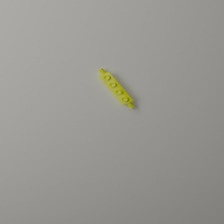

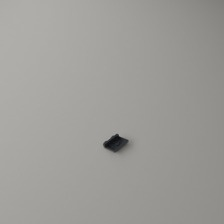

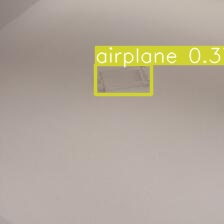

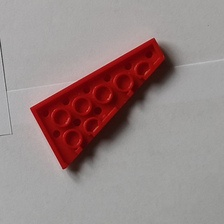

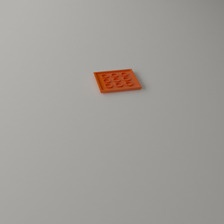

In [56]:
for name in get_file_names(folder_name):
    img = loadImage(name, folder_name)
    render(img)